In [1]:
import glob
import re
import cv2
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt 

from pathlib import Path
from PIL import Image

from ultralytics.utils.metrics import DetMetrics, ConfusionMatrix
from sahi import AutoDetectionModel
from ultralytics.utils import metrics

from utils import plot_bboxes, detection_metrics, convert_yolo_to_torch, sliced_inference, load_labels

In [2]:
IMAGE_WIDTH = 2339
IMAGE_HEIGHT = 1653
X1 = 100
X2 = 1779
Y1 = 200
Y2 = 1403

In [246]:
CONFIDENCE_THRESHOLD = 0.75
IOU_THRESHOLD = 0.5

In [253]:
model = AutoDetectionModel.from_pretrained(
    model_type='yolov8',
    model_path='runs/detect/Single Class 200E (Single Resolution Slices)/weights/best.pt',
    confidence_threshold = CONFIDENCE_THRESHOLD,
    device='cuda:0',
)

root = Path().resolve().parents[1]

In [254]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

root = Path().resolve().parents[1]
im_path = root / 'Data' / 'test' / 'fw_system' / 'fw_system-1_cropped.jpg'
im = Image.open(im_path)
test_labels = root / 'Data' / 'test' / 'fw_system' / 'labels' / 'cf884cd3-fw_system-1.txt'

In [255]:
label_tensor = load_labels(test_labels)
label_tensor_torch = convert_yolo_to_torch(label_tensor, height=IMAGE_HEIGHT, width=IMAGE_WIDTH, x1=X1, y1=Y1, cropped=True)

results = sliced_inference(model, img_path=str(im_path), slice_height=320, slice_width=320, h_ratio=0.15, w_ratio=0.15)
results.export_visuals(export_dir=root, hide_labels=True)

Performing prediction on 30 slices.


In [256]:
pred_bboxes = torch.tensor([x.bbox.to_xyxy() for x in results.object_prediction_list])
pred_conf = torch.tensor([x.score.value for x in results.object_prediction_list])
pred_class = torch.tensor([x.category.id for x in results.object_prediction_list])

prediction_length = len(results.object_prediction_list)
detections = torch.zeros((prediction_length, 6))

In [257]:
iou = metrics.box_iou(label_tensor_torch.to(device), pred_bboxes.to(device), eps=1e-07)
mean_iou, tp, fp, fn = detection_metrics(iou, iou_threshold=IOU_THRESHOLD)
print(f"Mean IOU: {mean_iou:.3f}")
print(f"Overall Box Recall: {tp / (tp + fn):.3f}")
print(f"Overall Box Precision: {tp /(tp + fp):.3f}")

Mean IOU: 0.695
Overall Box Recall: 0.736
Overall Box Precision: 0.942


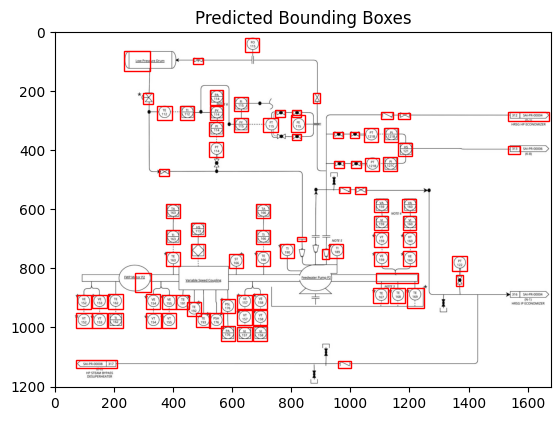

In [258]:
im_np = np.array(im)
plot_bboxes(im_np, pred_bboxes.cpu(), box_color='r', title='Predicted Bounding Boxes')

## Up-scale Spec Images to Training Image Resolution (5,268 x 4,011)

In [5]:
spec_imgs_path = root / 'Data' / 'test' / 'spec' / 'images' / '*.jpg'
spec_imgs = glob.glob(str(spec_imgs_path))

for img_path in spec_imgs:
    
    img_dir = re.findall('(.*)\\\\.*\.jpg', img_path)[0]
    img_name = re.findall('.*\\\\(.*).jpg', img_path)[0]

    img = cv2.imread(img_path)
    
    (wt, ht) = 5268, 4011 # target image size
    (h, w) = img.shape[:2] # given image size
    fx = w / wt
    fy = h / ht
    f = max(fx, fy)
    newSize = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1)) 
    
    upscaled_img = cv2.resize(img,newSize, interpolation=cv2.INTER_CUBIC)
    write_path = img_dir + '\\' + img_name + '_upscaled.jpg'
    cv2.imwrite(write_path, upscaled_img)

## Evaluate Classification Performance at Various Resolutions 

In [45]:
spec_imgs_path = root / 'Data' / 'test' / 'spec' / 'images' / '*.jpg'
spec_imgs = glob.glob(str(spec_imgs_path))

spec_labels_path = root / 'Data' / 'test' / 'spec' / 'labels' / '*.txt'
spec_labels = glob.glob(str(spec_labels_path))

results_dict = {}

for img, lbl in zip(spec_imgs, spec_labels):
    file_name = re.findall('.*\\\\(.*)\.jpg', img)[0]
    
    im = Image.open(img)
    width, height = im.size

    label_tensor = load_labels(lbl)
    label_tensor_torch = convert_yolo_to_torch(label_tensor, height=height, width=width, x1=X1, y1=Y1, cropped=False)

    prediction_path = root / 'Data' / 'test' / 'spec' / 'predictions' / file_name
    
    slice_sizes = [240, 360, 480, 640, 800]
    for slice in slice_sizes:
        results = sliced_inference(model, img_path=str(img), slice_height=slice, slice_width=slice, h_ratio=0.2, w_ratio=0.2)
        #results.export_visuals(export_dir=prediction_path, hide_labels=True)
        pred_bboxes = torch.tensor([x.bbox.to_xyxy() for x in results.object_prediction_list])

        if not pred_bboxes.size()[0] == 0:
            iou = metrics.box_iou(label_tensor_torch.to(device), pred_bboxes.to(device), eps=1e-07)
            mean_iou, tp, fp, fn = detection_metrics(iou, iou_threshold=IOU_THRESHOLD)
            
            #print(f"Mean IOU: {mean_iou:.3f}")
            #print(f"Overall Box Recall: {tp / (tp + fn):.3f}")
            #print(f"Overall Box Precision: {tp /(tp + fp):.3f}")
            if file_name not in results_dict:
                results_dict[file_name] = {'iou': [], 'recall':[], 'precision': [], 'slice_size':[]}

            results_dict[file_name]['iou'].append(mean_iou)
            results_dict[file_name]['recall'].append(tp / (tp + fn))
            results_dict[file_name]['precision'].append(tp /(tp + fp))
            results_dict[file_name]['slice_size'].append(slice)
        else:
            if file_name not in results_dict:
                results_dict[file_name] = {'iou': [], 'recall':[], 'precision': [], 'slice_size':[]}
            
            results_dict[file_name]['iou'].append(torch.tensor(0))
            results_dict[file_name]['recall'].append(0.0)
            results_dict[file_name]['precision'].append(0.0)
            results_dict[file_name]['slice_size'].append(slice)



Performing prediction on 546 slices.
Performing prediction on 252 slices.
Performing prediction on 143 slices.
Performing prediction on 80 slices.
Performing prediction on 56 slices.
Performing prediction on 588 slices.
Performing prediction on 266 slices.
Performing prediction on 140 slices.
Performing prediction on 88 slices.
Performing prediction on 48 slices.
Performing prediction on 560 slices.
Performing prediction on 266 slices.
Performing prediction on 140 slices.
Performing prediction on 88 slices.
Performing prediction on 48 slices.
Performing prediction on 567 slices.
Performing prediction on 252 slices.
Performing prediction on 143 slices.
Performing prediction on 80 slices.
Performing prediction on 56 slices.
Performing prediction on 567 slices.
Performing prediction on 252 slices.
Performing prediction on 154 slices.
Performing prediction on 80 slices.
Performing prediction on 56 slices.
Performing prediction on 567 slices.
Performing prediction on 252 slices.
Performing 

In [46]:
results_dict['instrumentation_signals-6_upscaled']

{'iou': [tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0)],
 'recall': [0.0, 0.0, 0.0, 0.0, 0.0],
 'precision': [0.0, 0.0, 0.0, 0.0, 0.0],
 'slice_size': [240, 360, 480, 640, 800]}

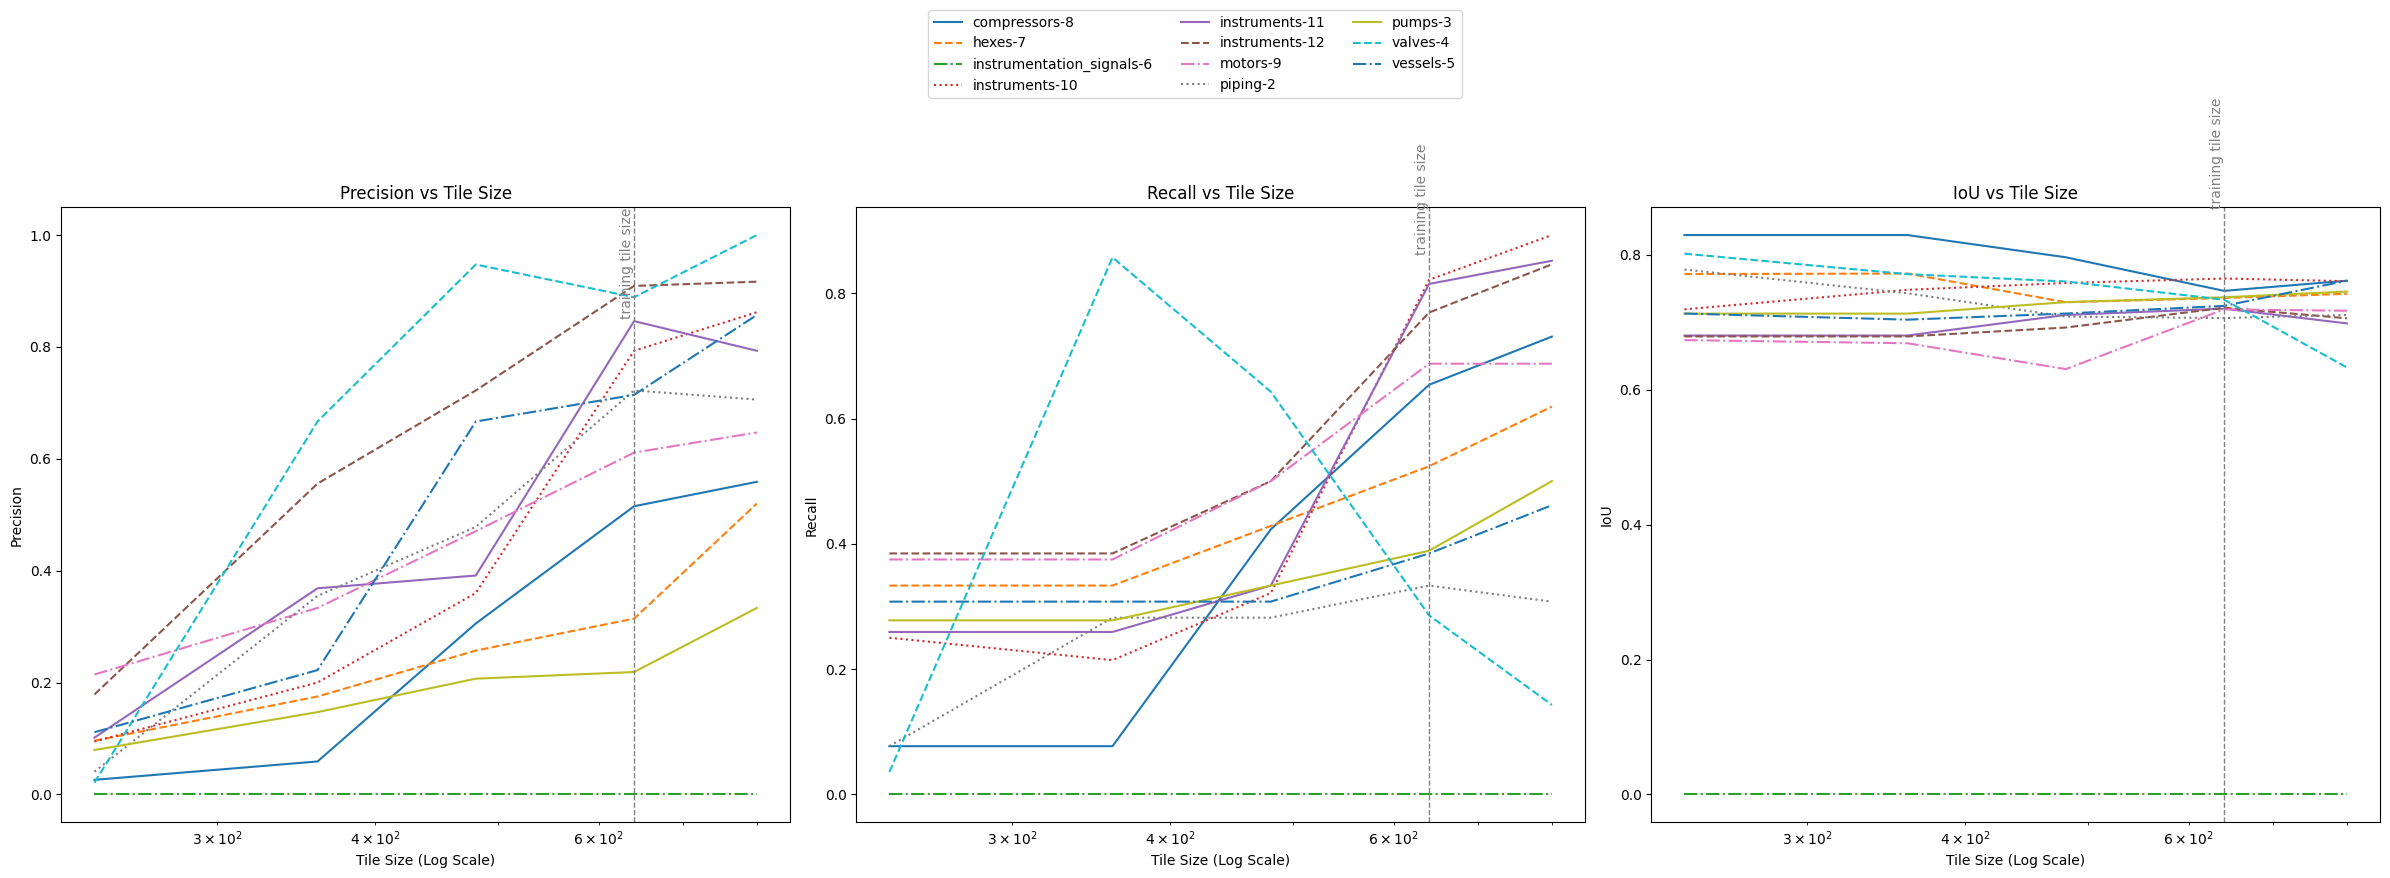

In [53]:
# Define line styles for differentiation
line_styles = ['-', '--', '-.', ':']

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
metric_names = ['precision', 'recall', 'iou']
y_labels = ['Precision', 'Recall', 'IoU']

# Variable to store line and label information for the legend
lines = []
labels = []

# Iterate over the metrics and plot each on a different subplot
for idx, metric in enumerate(metric_names):
    ax = axes[idx]
    
    for i, (file_name, data) in enumerate(results_dict.items()):
        # Move slice_sizes and values to CPU if they're tensors
        slice_sizes = [s.item() if isinstance(s, torch.Tensor) else s for s in data['slice_size']]
        values = [v.cpu().item() if isinstance(v, torch.Tensor) else v for v in data[metric]]
        
        # Plot and store the line and label for the legend
        line, = ax.plot(slice_sizes, values, linestyle=line_styles[i % len(line_styles)], label=file_name)
        
        # Collect lines and labels once
        if idx == 0:
            lines.append(line)
            legend_name = re.findall('(.*)_', file_name)[0]
            labels.append(legend_name)

    ax.set_xscale('log')  # Set x-axis to log scale
    ax.set_xlabel('Tile Size (Log Scale)')
    ax.set_ylabel(y_labels[idx])
    ax.set_title(f'{y_labels[idx]} vs Tile Size')
    ax.axvline(x=640, color='grey', linestyle='--', linewidth=1)
    ax.text(640, 0.95, 'training tile size', color='grey', rotation=90, va='center', ha='right')

# Add a single legend outside the subplots
fig.legend(lines, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.1))

# Adjust layout
plt.tight_layout()
plt.show()

In [6]:
def convert_conf_tensor(probabilities, targets, NC):
    K = probabilities.size(0)
    
    # Initialize a zero tensor of shape (K, NC)
    output_tensor = torch.zeros((K, NC))
    
    # Use advanced indexing to assign probabilities at the target indices
    output_tensor[torch.arange(K), targets] = probabilities
    
    return output_tensor

In [28]:
def bool_tp(detections, gt_bboxes, gt_cls, confidence_thresh=0.5, iou_thresh=0.5):
    
    n_preds = detections.size(0)
    prediction_results = np.zeros((n_preds, 4))
    
    gt_classes = gt_cls.int()
    detection_classes = detections[:, 5].int()
    detection_scores = detections[:, 4]
    
    iou = metrics.box_iou(gt_bboxes, detections[:, :4])

    max_iou, gt_indices = torch.max(iou, dim=0)
    detection_indices = torch.arange(n_preds)
    bool_tp = torch.stack((detection_indices, gt_indices, max_iou), dim=1)

    prediction_results[:, 0] = detection_classes[bool_tp[:, 0].long()]
    prediction_results[:, 1] = gt_classes[bool_tp[:, 1].long()]
    prediction_results[:, 2] = bool_tp[:, -1]
    prediction_results[:, 3] = detection_scores
    

    bool_tp = np.where(
        (prediction_results[:, 0] == prediction_results[:, 1]) &
        (prediction_results[:, 3] > iou_thresh) &
        (prediction_results[:, 4] > confidence_thresh),
        True,
        False
    )

    print(bool_tp)
    
    return bool_tp



In [5]:
imgs_path = root / 'Data' / 'synthetic_1_cropped' / 'images' / 'test'/ '*.jpg'
imgs = glob.glob(str(imgs_path))

annotations_path = root / 'Data' / 'synthetic_1_cropped' / 'labels' / 'test'/ '*.txt'
annotations = glob.glob(str(annotations_path))

In [6]:
read_path = root / 'Data' / f'synthetic_1' / 'raw_labels' / '0'  / '0_symbols.npy'
data_df = pd.DataFrame(np.load(read_path, allow_pickle=True))

In [ ]:
NC = 32


for i, (img, annotation) in enumerate(zip(imgs, annotations)):

    save_path = root / 'Data' / 'test' / f'{475 + i}_symbols.npy'
    
    results = sliced_inference(model, img_path=str(img), h_ratio=0.15, w_ratio=0.15)
    
    pred_bboxes = np.array(
        [np.array([int(y) for y in x.bbox.to_xyxy()]) for x in results.object_prediction_list]
    )
    
    pred_class = np.array([x.category.id + 1 for x in results.object_prediction_list])

    labels = load_labels(annotation)
    
    labels_torch = convert_yolo_to_torch(labels, IMAGE_HEIGHT, IMAGE_WIDTH, cropped=False)
    pred_bboxes_torch = torch.tensor(pred_bboxes)
    
    iou = metrics.box_iou(labels_torch.to(device), pred_bboxes_torch.to(device), eps=1e-07)
    max_iou = iou.max(dim=0)

    df = pd.DataFrame({
        'name': [f'symbol_{i}' for i in range(1, len(pred_class) + 1)],
        'bbox_coordinates': pred_bboxes.tolist(),
        'label': pred_class,
        'iou': max_iou[0].tolist()
    }).to_numpy()
    
    np.save(save_path, df)

In [7]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchmetrics.classification import MulticlassAUROC
from torchmetrics.classification import MulticlassPrecisionRecallCurve

c:\Users\Andrew Deur\miniconda3\envs\capstone\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [38]:
imgs_path = root / 'Data' / 'synthetic_1_cropped' / 'images' / 'test'/ '*.jpg'
imgs = glob.glob(str(imgs_path))

annotations_path = root / 'Data' / 'synthetic_1_cropped' / 'labels' / 'test'/ '*.txt'
annotations = glob.glob(str(annotations_path))


map_metric = MeanAveragePrecision(iou_type='bbox', class_metrics=True, iou_thresholds=[0.75], max_detection_thresholds=[50, 100, 150])
preds, targets = [], []
ious = []
fp, tp, fn = [], [], []

for img, annotation in zip(imgs, annotations):
    
    # Format labels
    labels_tensor = load_labels(annotation)
    target = labels_tensor[:, 0].int()
    labels_torch = convert_yolo_to_torch(labels_tensor, IMAGE_HEIGHT, IMAGE_WIDTH, x1=0, y1=0, cropped=False)
    
    # Get SAHI inference results
    results = sliced_inference(model, img_path=str(img), slice_height=640, slice_width=640, h_ratio=0.15, w_ratio=0.15)
    bboxes = torch.tensor([x.bbox.to_xyxy() for x in results.object_prediction_list])
    scores = torch.tensor([x.score.value for x in results.object_prediction_list])
    predicted_class = torch.tensor([x.category.id for x in results.object_prediction_list])

    preds.append({"boxes": bboxes, "scores": scores, "labels": predicted_class})
    targets.append({"boxes": labels_torch, "labels": target})

    iou = metrics.box_iou(labels_torch.to(device), bboxes.to(device), eps=1e-07)
    overall_iou, true_positives, false_positives, false_negatives = detection_metrics(iou, iou_threshold=0.5)

    fp.extend([false_positives])
    tp.extend([true_positives])
    fn.extend([false_negatives])
    ious.extend([overall_iou.item()])
    
    #prediction_length = len(results.object_prediction_list)
    #detections = torch.zeros((prediction_length, 6))
    
    # Each row should contain (x1, y1, x2, y2, conf, class)
    #detections[:, :4] = pred_bboxes
    #detections[:, 4] = pred_conf
    #detections[:, -1] = pred_class

    #tp = bool_tp(detections, label_tensor_torch, target)
map_metric.update(preds, targets)


Performing prediction on 80 slices.
Performing prediction on 80 slices.
Performing prediction on 80 slices.
Performing prediction on 80 slices.
Performing prediction on 80 slices.
Performing prediction on 80 slices.
Performing prediction on 80 slices.
Performing prediction on 80 slices.
Performing prediction on 80 slices.
Performing prediction on 80 slices.
Performing prediction on 80 slices.
Performing prediction on 80 slices.
Performing prediction on 80 slices.
Performing prediction on 80 slices.
Performing prediction on 80 slices.
Performing prediction on 80 slices.
Performing prediction on 80 slices.
Performing prediction on 80 slices.
Performing prediction on 80 slices.
Performing prediction on 80 slices.
Performing prediction on 80 slices.
Performing prediction on 80 slices.
Performing prediction on 80 slices.
Performing prediction on 80 slices.
Performing prediction on 80 slices.


In [40]:
results = map_metric.compute()

print(f"Mean IOU: {sum(ious) / len(ious):.3f}")
print(f"Overall Box Recall: {sum(tp) / (sum(tp) + sum(fn)):.3f}")
print(f"Overall Box Precision: {sum(tp)  /(sum(tp) + sum(fp)):.3f}")

Mean IOU: 0.955
Overall Box Recall: 1.000
Overall Box Precision: 0.998


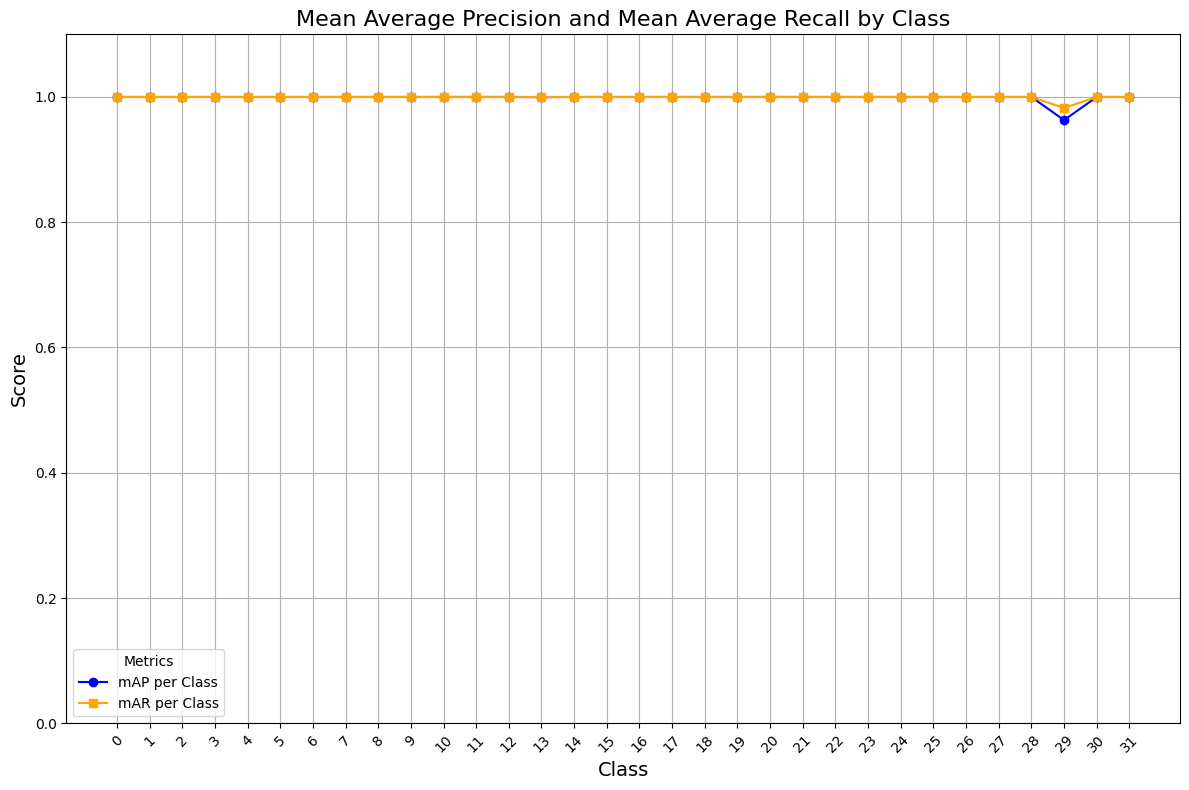

In [41]:
import matplotlib.pyplot as plt


map_per_class = results["map_per_class"].tolist()
mar_150_per_class = results["mar_150_per_class"].tolist()

# Set up the figure
fig, ax = plt.subplots(figsize=(12, 8))  # Set figure size

# Create an x-axis range based on the number of classes
x = np.arange(len(map_per_class))

# Plotting the metrics you want
ax.plot(x, map_per_class, marker='o', label='mAP per Class', color='blue')
ax.plot(x, mar_150_per_class, marker='s', label='mAR per Class', color='orange')

# Customize the plot
ax.set_xlabel('Class', fontsize=14)
ax.set_ylabel('Score', fontsize=14)
ax.set_title('Mean Average Precision and Mean Average Recall by Class', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels([str(i) for i in range(len(map_per_class))], rotation=45)  # Adjust for class labels
ax.set_ylim(0, 1.1)
ax.legend(title='Metrics')
ax.grid(True)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

In [23]:
# Data as a list of dictionaries for easier access
data = [
    {"Paper Precision": 0.93, "Paper Recall": 0.88},
    {"Paper Precision": 0.97, "Paper Recall": 0.97},
    {"Paper Precision": 0.97, "Paper Recall": 0.85},
    {"Paper Precision": 0.97, "Paper Recall": 0.90},
    {"Paper Precision": 0.99, "Paper Recall": 0.97},
    {"Paper Precision": 0.98, "Paper Recall": 0.97},
    {"Paper Precision": 0.97, "Paper Recall": 0.91},
    {"Paper Precision": 0.82, "Paper Recall": 0.96},
    {"Paper Precision": 0.77, "Paper Recall": 0.99},
    {"Paper Precision": 0.97, "Paper Recall": 0.96},
    {"Paper Precision": 0.74, "Paper Recall": 0.99},
    {"Paper Precision": 0.88, "Paper Recall": 0.79},
    {"Paper Precision": 0.97, "Paper Recall": 0.94},
    {"Paper Precision": 0.92, "Paper Recall": 0.96},
    {"Paper Precision": 0.95, "Paper Recall": 1.00},
    {"Paper Precision": 0.98, "Paper Recall": 0.94},
    {"Paper Precision": 0.81, "Paper Recall": 0.98},
    {"Paper Precision": 0.95, "Paper Recall": 0.99},
    {"Paper Precision": 0.95, "Paper Recall": 0.72},
    {"Paper Precision": 0.96, "Paper Recall": 0.93},
    {"Paper Precision": 0.88, "Paper Recall": 0.99},
    {"Paper Precision": 0.94, "Paper Recall": 0.95},
    {"Paper Precision": 0.88, "Paper Recall": 0.96},
    {"Paper Precision": 0.98, "Paper Recall": 0.97},
    {"Paper Precision": 0.93, "Paper Recall": 0.74},
    {"Paper Precision": 0.89, "Paper Recall": 0.94},
    {"Paper Precision": 0.86, "Paper Recall": 0.90},
    {"Paper Precision": 0.96, "Paper Recall": 0.98},
    {"Paper Precision": 0.98, "Paper Recall": 0.98},
    {"Paper Precision": 0.89, "Paper Recall": 0.91},
    {"Paper Precision": 0.90, "Paper Recall": 0.89},
    {"Paper Precision": 0.92, "Paper Recall": 0.95},
]

# Extracting values into lists
paper_precision = [entry["Paper Precision"] for entry in data]
paper_recall = [entry["Paper Recall"] for entry in data]

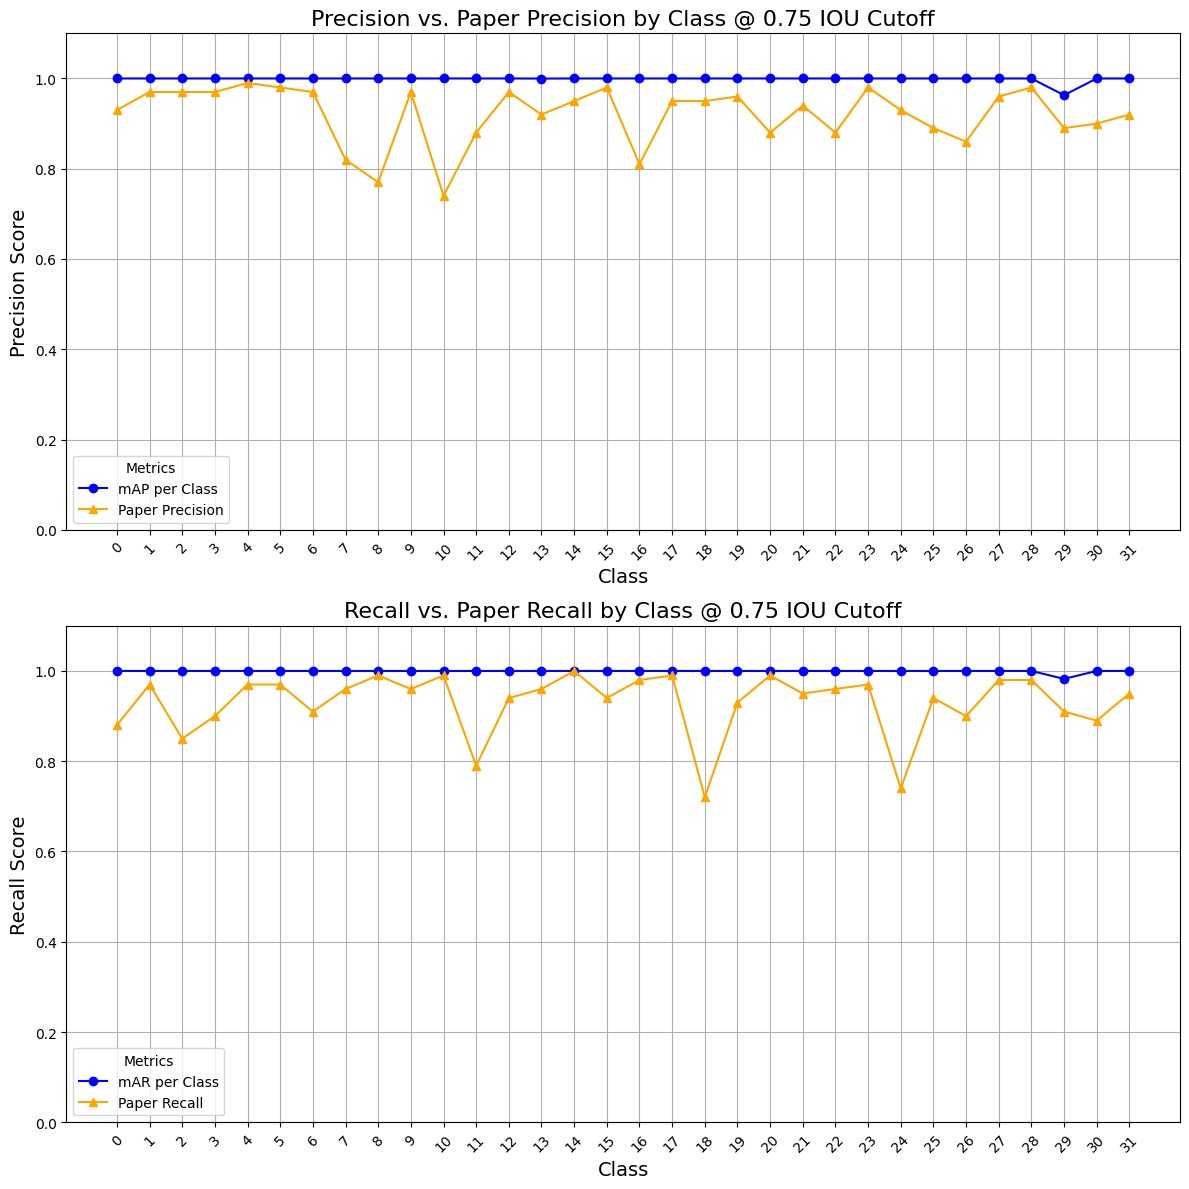

In [42]:
map_per_class = results["map_per_class"].tolist()
mar_150_per_class = results["mar_150_per_class"].tolist()

# Convert paper precision and recall to lists (assuming they're tensors)
paper_precision = [float(p) for p in paper_precision]  # Replace with your actual paper precision values
paper_recall = [float(r) for r in paper_recall]          # Replace with your actual paper recall values

# Set up the figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))  # Set figure size

# Create an x-axis range based on the number of classes
x = np.arange(len(map_per_class))

# Plotting the metrics for Precision
ax1.plot(x, map_per_class, marker='o', label='mAP per Class', color='blue')
ax1.plot(x, paper_precision, marker='^', label='Paper Precision', color='orange')

# Customize the precision plot
ax1.set_xlabel('Class', fontsize=14)
ax1.set_ylabel('Precision Score', fontsize=14)
ax1.set_title('Precision vs. Paper Precision by Class @ 0.75 IOU Cutoff', fontsize=16)
ax1.set_xticks(x)
ax1.set_xticklabels([str(i) for i in range(len(map_per_class))], rotation=45)  # Adjust for class labels
ax1.set_ylim(0, 1.1)
ax1.legend(title='Metrics')
ax1.grid(True)

# Plotting the metrics for Recall
ax2.plot(x, mar_150_per_class, marker='o', label='mAR per Class', color='blue')
ax2.plot(x, paper_recall, marker='^', label='Paper Recall', color='orange')

# Customize the recall plot
ax2.set_xlabel('Class', fontsize=14)
ax2.set_ylabel('Recall Score', fontsize=14)
ax2.set_title('Recall vs. Paper Recall by Class @ 0.75 IOU Cutoff', fontsize=16)
ax2.set_xticks(x)
ax2.set_xticklabels([str(i) for i in range(len(map_per_class))], rotation=45)  # Adjust for class labels
ax2.set_ylim(0, 1.1)
ax2.legend(title='Metrics')
ax2.grid(True)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

In [ ]:
print("Mean Average Precision (mAP):", results["map"])
print("Mean Average Precision at 50 IoU (mAP@50):", results["map_50"])
print("Mean Average Precision at 75 IoU (mAP@75):", results["map_75"])
print("Average Precision per class:", results["map_per_class"])
print("Average Recall per class:", results["mar_150_per_class"])

In [99]:
with open(root / 'results-1.md', "w") as file:
    file.write("|   | Our Precision | Our Recall | Paper Precision | Paper Recall | \n |---|----------------|-------------|-----------------|--------------| \n")
    for i, (ap, ar) in enumerate(zip(results["map_per_class"],  results["mar_150_per_class"])):

        ap = round(ap.item(), 2)
        ar = round(ar.item(), 2)

        if ap > paper_precision[i]:
            ap = f'**{ap}**'
            lit_precision = paper_precision[i]
        else:
            lit_precision = f'**{paper_precision[i]}**'

        if ar > float(paper_recall[i]):
            ar = f'**{ar}**'
            lit_recall = paper_recall[i]
        else:
            lit_recall = f'**{paper_recall[i]}**'
        
        file.write(f"| {i} | {ap} | {ar} | {lit_precision} | {lit_recall} | \n")

In [ ]:
iou = metrics.box_iou(label_tensor_torch.to(device), pred_bboxes.to(device), eps=1e-07)
detection_metrics(iou, iou_threshold=IOU_THRESHOLD)

In [ ]:
im = Image.open(img)
im_np = np.array(im)
plot_bboxes(im_np, pred_bboxes.cpu(), box_color='r', title='Predicted Bounding Boxes')

In [ ]:
classification_metrics = DetMetrics()
classification_metrics.process()